# Project 6: News Summarization

### Rubric :

#### 1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
    - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
    
#### 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. 
    - 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.
    
#### 3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. 
     - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

In [1]:
# import & check version

from importlib.metadata import version
import nltk
nltk.download('stopwords')  # download general stopwords


import tensorflow as tf
from summa.summarizer import summarize
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


print(nltk.__version__)
print(tf.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


### Load data

In [52]:
# request data

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')


In [3]:
# data info

print(data.info)  # [98401 rows x 2 columns]
data.sample(10)   # columns - > headlines, text

<bound method DataFrame.info of                                                headlines  \
0      upGrad learner switches to career in ML & Al w...   
1      Delhi techie wins free food from Swiggy for on...   
2      New Zealand end Rohit Sharma-led India's 12-ma...   
3      Aegon life iTerm insurance plan helps customer...   
4      Have known Hirani for yrs, what if MeToo claim...   
...                                                  ...   
98396  CRPF jawan axed to death by Maoists in Chhatti...   
98397  First song from Sonakshi Sinha's 'Noor' titled...   
98398         'The Matrix' film to get a reboot: Reports   
98399  Snoop Dogg aims gun at clown dressed as Trump ...   
98400  Madhesi Morcha withdraws support to Nepalese g...   

                                                    text  
0      Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1      Kunal Shah's credit card bill payment platform...  
2      New Zealand defeated India by 8 wickets in the...  
3      With

,headlines,text
64831,Bots behind Rahul Gandhi's popularity on Twitt...,"Automated bots with a Russian, Kazakh or Indon..."
51620,India register 2nd straight 10-wicket win in I...,The Indian team beat Zimbabwe and registered t...
13619,"Sajid said 'If I like what I see, you might ge...",Actress Mandana Karimi has alleged that filmma...
95182,Drunk airline pilot who passed out before take...,A drunk airline pilot who passed out in the co...
50844,"Fan hacks India pacer's FB account, sends 'I l...",A fan allegedly hacked Facebook and other soci...
21441,Former PM Atal Bihari Vajpayee's condition cri...,Former Prime Minister Atal Bihari Vajpayee's c...
16585,"Officer slammed my passport, yelled: Richa cla...",Actress Richa Chadha has claimed she faced rac...
6428,Former Army chief JJ Singh resigns from Shirom...,Former Army chief JJ Singh has resigned from t...
90110,Comedian to be investigated over sexual joke o...,American comedian Stephen Colbert will be inve...
84267,Aryan gets excited telling me about gaalis he'...,Shah Rukh Khan has revealed that his eldest so...


### Remove duplicates & nulls

In [4]:
# check uniqueness

print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())  # target

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [40]:
# drop duplicates only for text -> could have same headlines with different text

data.drop_duplicates(subset = ['text'], inplace=True)
data_orig = data.copy()
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [41]:
print(data.isnull().sum())  # null cell check

headlines    0
text         0
dtype: int64


### Preprocessing data
- text normalization
- remove stopwords

#### text normalization dictionary

[ref](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# preprocess text column

clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))
    

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
# preprocess headlines column

clean_headlines = []

for headline in data['headlines']:
    clean_headlines.append(preprocess_sentence(headline, False))  # False: not to remove stopwords

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [14]:
# preprocessing took so long..., so I saved preprocessed ones

import json

with open('clean_text.json', 'w') as file:
    json.dump(clean_text, file)
    
with open('clean_headlines.json', 'w') as file:
    json.dump(clean_headlines, file)

In [9]:
import json

with open('clean_text.json', 'r') as file:
    loaded_text = json.load(file)
    
with open('clean_headlines.json', 'r') as file:
    loaded_headlines = json.load(file)

In [10]:
print(clean_headlines[:5])
print(loaded_headlines[:5])

NameError: name 'clean_headlines' is not defined

In [10]:
data['text'] = loaded_text
data['headlines'] = loaded_headlines

data.replace('', np.nan, inplace=True)  # There could be some blanks due to preprocessing
data.isnull().sum()

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### Max token length selection

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


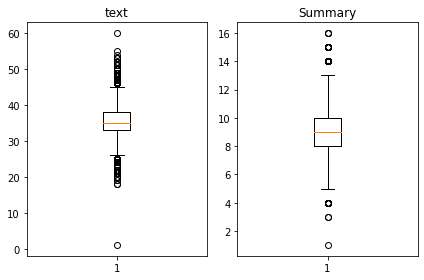

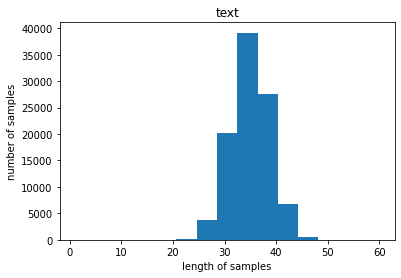

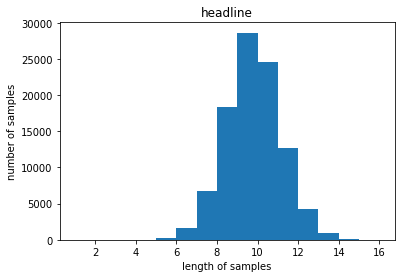

In [11]:
# 길이 분포 출력

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('headline')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 15)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 15)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
text_max_len = 40
headline_max_len = 10

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])


전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [13]:
filtered_data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) 
                     & data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]

print('전체 샘플수 :', (len(filtered_data)))

전체 샘플수 : 74102


### insert start, end token

In [14]:
filtered_data['decoder_input'] = filtered_data['headlines'].apply(lambda x : 'sostoken '+ x)
filtered_data['decoder_target'] = filtered_data['headlines'].apply(lambda x : x + ' eostoken')
filtered_data.head()

/tmp/ipykernel_119/1202646252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['decoder_input'] = filtered_data['headlines'].apply(lambda x : 'sostoken '+ x)
/tmp/ipykernel_119/1202646252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['decoder_target'] = filtered_data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [15]:
encoder_input = np.array(filtered_data['text']) # 인코더의 입력
decoder_input = np.array(filtered_data['decoder_input']) # 디코더의 입력
decoder_target = np.array(filtered_data['decoder_target']) # 디코더의 레이블

### data random shuffling & 20% validation split

In [16]:
# random shuffle

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [17]:
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


In [18]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [19]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61663
등장 빈도가 6번 이하인 희귀 단어의 수: 42374
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19289
단어 집합에서 희귀 단어의 비율: 68.71868057019607
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.192155074227543


In [20]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [21]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [22]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [23]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27294
등장 빈도가 4번 이하인 희귀 단어의 수: 17148
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10146
단어 집합에서 희귀 단어의 비율: 62.826994943943724
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.050397586681447


In [24]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [25]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14819
테스트 레이블의 개수 : 14819


In [26]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='pre')

In [27]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [28]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [29]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [30]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 57s 85ms/step - loss: 6.3357 - val_loss: 5.9446
Epoch 2/50
232/232 [==============================] - 19s 81ms/step - loss: 5.9782 - val_loss: 5.8373
Epoch 3/50
232/232 [==============================] - 19s 83ms/step - loss: 5.8399 - val_loss: 5.7305
Epoch 4/50
232/232 [==============================] - 20s 84ms/step - loss: 5.5818 - val_loss: 5.4201
Epoch 5/50
232/232 [==============================] - 20s 86ms/step - loss: 5.3341 - val_loss: 5.4053
Epoch 6/50
232/232 [==============================] - 20s 87ms/step - loss: 5.0887 - val_loss: 5.0223
Epoch 7/50
232/232 [==============================] - 20s 87ms/step - loss: 4.8819 - val_loss: 5.1681
Epoch 8/50
232/232 [==============================] - 20s 87ms/step - loss: 4.7066 - val_loss: 4.7506
Epoch 9/50
232/232 [==============================] - 20s 86ms/step - loss: 4.5434 - val_loss: 4.6687
Epoch 10/50
232/232 [==============================] - 20s 87ms/step - loss: 4.390

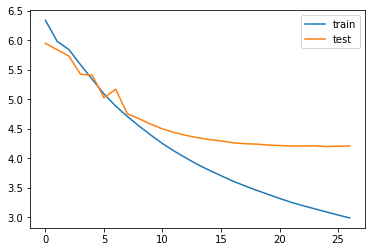

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [34]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [35]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [37]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [51]:
for i in range(50, 100):  
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 headline :", seq2headline(decoder_input_test[i]))
    print("예측 headline :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : team researchers china used gene editing technique get produce spider silk team replaced part genome golden orb web spider spider silk used create micro delivering cancer drugs repair damaged nerves create better bullet proof vests 
실제 headline : gene editing allows to create spider silk 
예측 headline :  scientists find new zealand museum to get cr from


원문 : indian rounder hardik pandya shared selfie entire indian team visiting indian summer festival held melbourne ahead rd india australia test photo caption read best selfie ever indian team official instagram account cricket australia official twitter account shared posts event 
실제 headline : pandya shares best selfie ever as team india attends festival 
예측 headline :  india first indian cricketer to play in india cricket


원문 : manchester united crashed champions league pre quarterfinals losing sevilla old trafford wednesday first time sevilla five time europa league champions reached champions league quarterfinals barcelona ch

예측 headline :  bengaluru metro to install bengaluru metro stations for hindi


원문 : congress spokesperson randeep surjewala tuesday said new slogan pm narendra modi led government ka vikas aur ka saath slamming pm modi finance minister arun jaitley silence surjewala added scams worth around carried nda rule 
실제 headline : govt slogan is ka vikas ka cong 
예측 headline :  pm modi should be removed from congress cong leader


원문 : camera maker gopro ceo nick best compensated us executive paid cash compensation pay totalled million company shares soared ipo boosting value equity grant according bloomberg company also announced plans cut workforce 
실제 headline : ceo who once had mn salary to get for 
예측 headline :  bitcoin ceo mark net worth cr from last year


원문 : rjd leader tejashwi yadav sunday met bsp chief mayawati lucknow day latter announced alliance akhilesh yadav samajwadi party said father jailed rjd chief lalu prasad yadav wanted grand alliance uttar pradesh bsp sp contest seats 

예측 headline :  hc rejects plea against police for arrest of women


원문 : speaking television chat show actor zac recalled incident almost died cycling trip london actor hugh jackman zac said followed hugh around cars suddenly double decker bus right front slammed brakes went front narrowly missed death 
실제 headline : almost died on cycling trip with hugh jackman 
예측 headline :  tv actor passes away after being stabbed by him


원문 : meth addicted snake spent seven months corrective services wildlife care centre australia set released rehab reptile seized raid drug lab reportedly developed habit fumes particles manufacturing ice lab skin nn 
실제 headline : meth snake to be released from 
예측 headline :  indians are the most number of the year in


원문 : former un secretary general nobel peace prize winner passed away saturday aged hospital switzerland diplomat ghana worked combat hiv especially africa advocated expansion un security council also served un special representative tasked resol

## Extractive Text Summarization with summa

In [58]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [59]:
summa_data['text'][22578]

'A team of researchers in China used a gene editing technique to get silkworms to produce spider silk. The team replaced a part of a silkworm genome with a snippet from a golden orb-web spider. Spider silk can be used to create micro-capsules for delivering cancer drugs, repair damaged nerves and create better bullet-proof vests.'

In [61]:
print('Summary:')
print(summarize(summa_data['text'][22578], words=13))

Summary:
A team of researchers in China used a gene editing technique to get silkworms to produce spider silk.


In [62]:
summa_data['text'][4980]

'Indian all-rounder Hardik Pandya shared a selfie with the entire Indian team when they were visiting the Indian Summer Festival which was held in Melbourne ahead of the 3rd India-Australia Test. The photo\'s caption read, "Best selfie ever". The Indian team\'s official Instagram account and the Cricket Australia\'s official Twitter account shared posts from the event.'

In [63]:
print('Summary:')
print(summarize(summa_data['text'][4980], words=13))

Summary:



In [64]:
summa_data['text'][43939]

'Manchester United crashed out of the Champions League in the pre-quarterfinals after losing 1-2 to Sevilla at Old Trafford on Wednesday. This is the first time Sevilla, five-time Europa League champions, have reached Champions League quarterfinals. Barcelona and Chelsea, who played out a 1-1 draw in the first leg, will play the second leg of their last 16 tie today.'

In [65]:
print('Summary:')
print(summarize(summa_data['text'][43939], words=13))

Summary:
Manchester United crashed out of the Champions League in the pre-quarterfinals after losing 1-2 to Sevilla at Old Trafford on Wednesday.


|Text|실제 Headline|예측된 Headline|Summuarized text|
|------|---|---|---|
|A team of researchers in China used a gene editing technique to get silkworms to produce spider silk. The team replaced a part of a silkworm genome with a snippet from a golden orb-web spider. Spider silk can be used to create micro-capsules for delivering cancer drugs, repair damaged nerves and create better bullet-proof vests.|gene editing allows to create spider silk |scientists find new zealand museum to get cr from|A team of researchers in China used a gene editing technique to get silkworms to produce spider silk.|
|Indian all-rounder Hardik Pandya shared a selfie with the entire Indian team when they were visiting the Indian Summer Festival which was held in Melbourne ahead of the 3rd India-Australia Test. The photo\'s caption read, "Best selfie ever". The Indian team\'s official Instagram account and the Cricket Australia\'s official Twitter account shared posts from the event.|pandya shares best selfie ever as team india attends festival|india first indian cricketer to play in india cricket|-|
|Manchester United crashed out of the Champions League in the pre-quarterfinals after losing 1-2 to Sevilla at Old Trafford on Wednesday. This is the first time Sevilla, five-time Europa League champions, have reached Champions League quarterfinals. Barcelona and Chelsea, who played out a 1-1 draw in the first leg, will play the second leg of their last 16 tie today.|manchester united knocked out of champions league|chelsea lose their own pl match in last years|Manchester United crashed out of the Champions League in the pre-quarterfinals after losing 1-2 to Sevilla at Old Trafford on Wednesday.|

## 분석

summa 패키지의 summarize를 사용한 경우가 내가 설계한 모델에 비해 텍스트의 키워드를 찾는데에는 더 우수한 성능을 보여줬다. 그러나 summarize는 때때로 요약을 하지 않는 경우가 있는데, 문장의 수가 적거나 키워드를 찾지 못할때 ''를 리턴한다. 이는 표의 두번째 예시에서 볼 수 있듯이 output이 없음을 확인 할 수 있다. summarize가 이번 프로젝트에서는 비교 우위의 성능을 보여주고 있으나, 내가 사용한 모델을 더 fine tunning 할 수 있다면 더 다양한 상황에서 동등하거나 더 높은 성능을 낼 수 있을거라 생각한다. 
